In [273]:
import pandas as pd
ORIGINAL_DATA_FILE ='[new] yancheng_train_20171226_2.csv'
df = pd.read_csv('../RawData/'+ORIGINAL_DATA_FILE)
classList = df['class_id'].unique()

mutipleValueList = set()
for columnName in df.columns:
    for classId in classList:
        tempDf = df[df['class_id']==classId]
        if len(tempDf[columnName].unique())>1:
            mutipleValueList.add(columnName)
columnsList = list(df.columns)
for mutipleValueColumn in mutipleValueList:
    columnsList.remove(mutipleValueColumn)
# columnsList.append('sale_date')
columnsList = columnsList + ['sale_date', 'price_level', 'rated_passenger', 'TR', 'fuel_type_id', 'newenergy_type_id']
resultDf = df.groupby(columnsList)['sale_quantity'].sum().to_frame()
resultDf.reset_index(level=columnsList, inplace=True)
def handleSaleDate(df):
    # split date to month and year
    def operateDateToYear(x):
        return x[:4]
    def operateDateToMonth(x):
        return x[4:]
    df['sale_date'] = df['sale_date'].astype('str')
    df['year'] = df['sale_date'].apply(operateDateToYear)
    df['month'] = df['sale_date'].apply(operateDateToMonth)
    df = df.drop(['sale_date'], axis=1)
    return df
resultDf = handleSaleDate(resultDf)
def mapPriceLevel(x):
    arr = x.split('-')
    if len(arr) < 2:
        return float(arr[0].split('W')[0])/2
    else:
        subArr = arr[1].split('W')
        return (float(arr[0]) + float(subArr[0]))/2
resultDf['price_level'] = resultDf['price_level'].apply(mapPriceLevel)
def mapRatedPassenger(x):
    monthMap = {'Jul':6,'May':5,'Aug':8}
    if '-' in x:
        arr = x.split('-')
        if arr[1] in monthMap.keys():
            arr[1] = monthMap.get(arr[1])
#             print(arr[1], 'in monthMap')
        return (float(arr[0]) + float(arr[1]))/2
    else:
        return float(x)
resultDf['rated_passenger'] = resultDf['rated_passenger'].apply(mapRatedPassenger)
def mapTR(x):
    if type(x)==str and ';' in x:
        nums = x.split(';')
        trNum = (float(nums[0]) + float(nums[1]))/2
        return trNum
    else:
        return float(x)
resultDf['TR'] = resultDf['TR'].apply(mapTR)

# resultDf = resultDf.drop('brand_id', axis=1)
resultDf = pd.get_dummies(resultDf, columns=['class_id', 
                                             'brand_id', 
                                             'department_id','year', 'month'
                                             ,'fuel_type_id'
                                             , 'newenergy_type_id'
                                            ])


c:\ricy\python\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


learningRate: 0.3 and maxDepth: 6 and train error: 95.22446813633626 and test error : 147.7799871162018


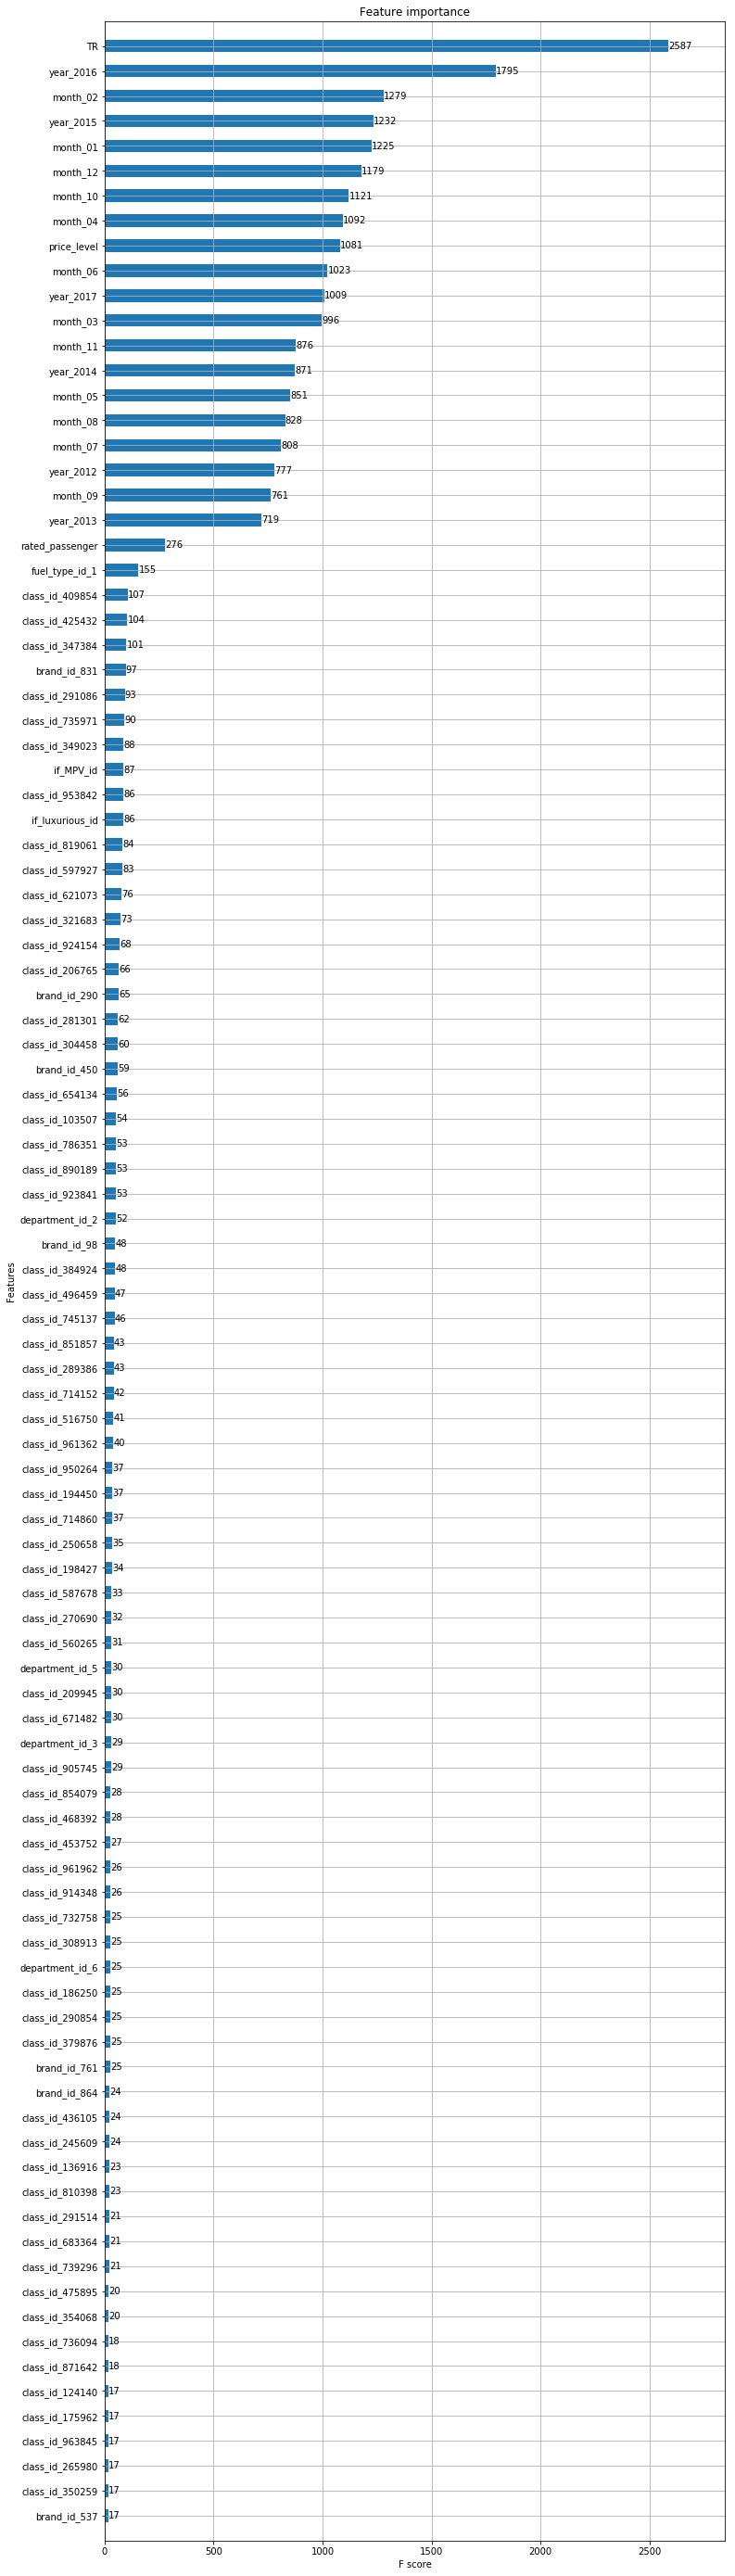

In [274]:
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import re
%matplotlib inline

resultDf = resultDf.sample(frac=1).reset_index(drop=True)

inputX = resultDf.drop('sale_quantity', axis=1)
inputY = resultDf['sale_quantity']
# inputY = resultArray.reshape((len(resultArray),1))
# train_x, test_x, train_y, test_y = train_test_split(inputX, inputY, test_size=0.2, random_state=42)
data_train, data_test, label_train, label_test = train_test_split(inputX, inputY, test_size = 0.1, random_state = 42)

dtrain = xgb.DMatrix(data_train, label_train)
dtest = xgb.DMatrix(data_test)

learningRateList = [0.1, 0.2, 0.3, 0.01, 0.03, 0.05]
maxDepthList = [5, 6, 7, 8, 9, 10]

testScore = 10000
trainScore = 10000
finalLearningRate = 0
finalMaxDepth = 0
model = 0

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

for learingRate in learningRateList:
    for maxDepth in maxDepthList:
        xgb_params = {
            'max_depth': maxDepth,
            'learning_rate': learingRate,
            'subsample': 1,
            'colsample_bytree': 1,
            'objective': 'reg:linear',
            'booster':'gbtree',
            'eval_metric': 'rmse',
            'silent': True,
            'gamma': 5,
            'n_estimators': 100
        }
        num_round = 200
        model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_round)
        train_rmse = rmse(label_train.values, model.predict(dtrain, ntree_limit=num_round))
        test_rmse = rmse(label_test.values, model.predict(dtest, ntree_limit=num_round))
        if test_rmse<testScore:
            trainScore = train_rmse
            testScore = test_rmse
            finalLearningRate = learingRate
            finalMaxDepth = maxDepth
print("learningRate: {} and maxDepth: {} and train error: {} and test error : {}".format(finalLearningRate, finalMaxDepth,
                                                                                         trainScore, testScore))
fig, ax = plt.subplots(1, 1, figsize=(12, 50))
xgb.plot_importance(model, max_num_features=100, height=0.5, ax=ax)

In [264]:
columnsList

['class_id',
 'brand_id',
 'department_id',
 'if_MPV_id',
 'if_luxurious_id',
 'sale_date',
 'price_level',
 'rated_passenger',
 'fuel_type_id',
 'newenergy_type_id',
 'TR']

In [165]:
columnNameList = [x for x in list(df.columns) if x not in ['sale_date', 'class_id', 'sale_quantity', 'price']]
for columnName in columnNameList:
    for classId in classList:
        tempDf = df[df['class_id']==classId]
        if len(tempDf[columnName].unique())>1 and columnName != '':
            print(classId, ' ', columnName, ' ', tempDf[columnName].unique())

745137   compartment   [3 2]
978089   compartment   [2 3]
349023   compartment   [3 2]
281792   compartment   [2 3]
289386   compartment   [3 2]
914348   compartment   [2 3]
248352   compartment   [3 2]
687270   type_id   [3 2]
687270   level_id   ['3' '1']
175962   TR   ['5' '6']
961962   TR   ['5' '6' '7']
409854   TR   ['6' '7' '5' '4']
437598   TR   ['6' '7']
603972   TR   ['0' '7' '6']
576298   TR   ['5' '6']
304458   TR   ['0' '5' '6' '4']
384924   TR   ['0' '6' '7']
591790   TR   ['0' '5' '6']
136916   TR   ['0' '6' '4' '5']
597927   TR   ['6' '7']
468392   TR   ['0' '5' '6']
356986   TR   ['0' '6']
851857   TR   ['9' '8']
290854   TR   ['0' '5' '6']
732758   TR   ['6' '8']
745137   TR   ['6' '5']
714860   TR   ['6' '7']
692703   TR   ['5' '7' '6']
978089   TR   ['5' '0' '6']
349023   TR   ['5' '6' '7']
281792   TR   ['7' '5']
379876   TR   ['6' '4' '5']
750340   TR   ['6' '5']
347384   TR   ['6' '7']
354068   TR   ['0' '5' '4' '6']
416749   TR   ['0' '6']
281301   TR   ['7' '5'

356986   if_charging   ['L' 'T']
290854   if_charging   ['L' 'T']
732758   if_charging   ['T' 'L']
289403   if_charging   ['L' 'T']
745137   if_charging   ['L' 'T']
714860   if_charging   ['L' 'T']
978089   if_charging   ['L' 'T']
349023   if_charging   ['L' 'T']
379876   if_charging   ['T' 'L']
347384   if_charging   ['L' 'T']
125403   if_charging   ['L' 'T']
281301   if_charging   ['T' 'L']
654134   if_charging   ['L' 'T']
425432   if_charging   ['L' 'T']
614059   if_charging   ['T' 'L']
527809   if_charging   ['T' 'L']
472603   if_charging   ['L' 'T']
124140   if_charging   ['T' 'L']
693436   if_charging   ['T' 'L']
453752   if_charging   ['T' 'L']
628041   if_charging   ['T' 'L']
378356   if_charging   ['L' 'T']
209945   if_charging   ['T' 'L']
245609   if_charging   ['L' 'T']
540712   if_charging   ['T' 'L']
103507   if_charging   ['L' 'T']
412240   if_charging   ['L' 'T']
713651   if_charging   ['T' 'L']
671482   if_charging   ['T' 'L']
580634   if_charging   ['L' 'T']
321683   i

175962   power   ['81/70' '81' '66' 81.0 66.0]
961962   power   ['81/70' '81' '66' '70' '96' 81.0 96.0 70.0 66.0]
527765   power   ['30' '36']
409854   power   ['110' '120' '145' '102' '98' 110.0 120.0 98.0]
437598   power   ['120' '110' '145' 145.0 110.0]
603972   power   ['140' '200' '150' '245' '165' '220' '228' '162' '132' '125' '188' '130'
 '213' 125.0 220.0 228.0 162.0 140.0 213.0 130.0 132.0 150.0 200.0 245.0]
576298   power   ['82' '83' '89' '90' '85' '108' '81.58' '121' 89.0 83.0 82.0 81.58]
304458   power   ['73' '90' '85' '103' 90.0 103.0]
384924   power   ['91' '137' '120' '187' '166' '190' '195' '134' '184' 166.0 187.0 137.0
 195.0 134.0 184.0 120.0]
591790   power   ['73' '90' '85' '103' 103.0 90.0]
136916   power   ['118' '110' '123' '135' '108' '109' 108.0 109.0 135.0 110.0 123.0]
597927   power   ['115' '132.4' '118' '180' '119' '121' '132' 121.0 119.0 132.0 180.0 118.0
 132.4]
468392   power   ['107' '137' '114' '132' '192' '115' 115.0 137.0 114.0]
356986   power   ['

436105   engine_torque   ['265' '176' '192' 176.0 265.0]
481950   engine_torque   ['252' '202' 202.0 252.0]
248352   engine_torque   ['135' '150.7' '132.4' '155' 135.0 155.0]
961362   engine_torque   ['200' '165' '154' '198' 198.0 200.0 165.0 190.0]
950264   engine_torque   ['350' '250' 350.0 250.0]
308913   engine_torque   ['225' '155' '200' 155.0 225.0]
250658   engine_torque   ['252' '253' 252.0]
621073   engine_torque   ['116' '146.5' '108' 146.5 108.0 116.0]
198427   engine_torque   ['140' '142' '185' 140.0]
651782   engine_torque   ['400' '355' '360' 355.0 400.0 360.0]
619401   engine_torque   ['170' '185' 170.0 185.0]
348641   engine_torque   ['135' '235' 135.0 235.0]
194450   engine_torque   ['265' '203' '184' 265.0 184.0 203.0]
206765   engine_torque   ['250' '146' 146.0 250.0]
178529   engine_torque   ['115' '85' '108' '103' '116' '90' 85.0 108.0 90.0 115.0]
953842   engine_torque   ['203' '265' 203.0 265.0]
395234   engine_torque   ['200' '280' '245' '230' 200.0 245.0 230.0 

425432   equipment_quality   [1265 1300 1290 1245 1210 1225 1270 1215 1323 1305 1285 1280 1325]
871642   equipment_quality   [1717 1592 1740 1756]
559132   equipment_quality   [1497 1458 1466 1471 1473 1481 1574 1456 1582 1484 1564 1581 1469 1529 1452]
819061   equipment_quality   [1431 1470 1580 1541 1423 1505 1540 1398]
614059   equipment_quality   [1640 1596 1577 1658 1746 1600 1590 1683 1626 1540 1605 1570 1545 1665 1650
 1630 1615 1660]
527809   equipment_quality   [1770 1800 1870 1769 1950 1775 1845 1740 1765 1848 1750 1954 1745 1880 1955]
472603   equipment_quality   [1315 1415 1320 1370 1450 1431 1418 1402 1401 1375 1440 1425]
124140   equipment_quality   [1665 1640 1626 1771]
291514   equipment_quality   [1290 1270 1325]
693436   equipment_quality   [1380 1340 1360 1320]
854079   equipment_quality   [1251 1275 1240]
453752   equipment_quality   [1615 1555 1560 1500 1530 1510 1570 1695 1610 1640 1515 1675 1540 1590 1485
 1565]
587678   equipment_quality   [1302 1200 1256 1248 1

250658   front_track   [1606 1596]
198427   front_track   [1490 1482]
194450   front_track   [1620 1550]
206765   front_track   [1540 1534]
178529   front_track   [1290 1280]
395234   front_track   [1584 1590]
360648   front_track   [1460 1470]
815230   front_track   [1544 1545]
437063   front_track   [1563 1559]
789290   front_track   [1460 1470]
961962   rear_track   [1500 1422]
409854   rear_track   [1565 1585]
603972   rear_track   [1622 1620 1618]
304458   rear_track   [1535 1520]
384924   rear_track   [1602 1574 1576]
591790   rear_track   [1535 1520]
597927   rear_track   [1621 1609 1601 1591 1595]
468392   rear_track   [1580 1585]
356986   rear_track   [1587 1574]
290854   rear_track   [1617 1580 1613 1565]
732758   rear_track   [1562 1529]
349023   rear_track   [1558 1561 1567 1565 1557]
281792   rear_track   [1509 1520 1506 1522]
379876   rear_track   [1550 1522]
354068   rear_track   [1540 1485 1530 1480]
125403   rear_track   [1603 1596 1626 1605 1601]
786351   rear_track  

In [203]:
df.groupby('price_level')['sale_quantity'].sum()

price_level
10-15W    1158367
15-20W     444910
20-25W     179928
25-35W     125177
35-50W     117719
5-8W       192779
50-75W      32600
5WL        138105
8-10W      156487
Name: sale_quantity, dtype: int64

Index(['sale_quantity', 'compartment', 'type_id', 'level_id', 'gearbox_type',
       'displacement', 'if_charging', 'price', 'driven_type_id',
       'emission_standards_id', 'power', 'cylinder_number', 'engine_torque',
       'car_length', 'car_width', 'car_height', 'total_quality',
       'equipment_quality', 'wheelbase', 'front_track', 'rear_track'],
      dtype='object')

In [222]:
df.groupby(['if_luxurious_id', 'price_level'])['sale_quantity'].sum().to_frame()

sale_quantity
if_luxurious_id price_level               
1               10-15W             1158367
                15-20W              444910
                20-25W              176335
                25-35W               80999
                35-50W               11139
                5-8W                192779
                5WL                 138105
                8-10W               156487
2               20-25W                3593
                25-35W               44178
                35-50W              106580
                50-75W               32600

In [284]:
type1Columns = ['class_id', 'compartment', 'brand_id', 'type_id', 'level_id', 'department_id', 'TR', 'sale_date',
              'gearbox_type', 'displacement', 'if_charging', 'price_level', 'driven_type_id', 'fuel_type_id',
              'newenergy_type_id', 'emission_standards_id', 'if_MPV_id', 'if_luxurious_id', 'cylinder_number', 'rated_passenger']
type2Columns = ['power', 'engine_torque', 'car_length', 'car_width', 'car_height', 'wheelbase', 'total_quality',
               'equipment_quality', 'front_track', 'rear_track']

In [289]:
# df = df.drop('sale_quantity', axis=1)
# temDf = df.groupby(type1Columns).count()
temDf = df[type1Columns]
testDf = temDf.groupby(columnsList).count()
testDf.index.is_unique

compartment  \
class_id brand_id department_id if_MPV_id if_luxurious_id sale_date price_level rated_passenger TR fuel_type_id newenergy_type_id                
103507   831      3             2         1               201503    10-15W      5               6  1            1                            2   
                                                                                                7  1            1                            1   
                                                          201504    10-15W      5               6  1            1                            5   
                                                                                                7  1            1                            1   
                                                          201505    10-15W      5               6  1            1                            5   
                                                                                                7  1            1                            1   
                                                          201506    10-15W      5               6  1            1                            6   
                                                                                                7  1            1                            1   
                                                          201507    10-15W      5               6  1            1                            5   
                                                                                                7  1            1                            1   
                                                          201508    10-15W      5               6  1            1                            3   
                                                                                                7  1            1                            1   
                                                          201509    10-15W      5               6  1            1                            6   
                                                                                                7  1            1                            1   
                                                          201510    10-15W      5               6  1            1                            4   
                                                                                                7  1            1                            2   
                                                          201511    10-15W      5               6  1            1                            5   
                                                                                                7  1            1                            1   
                                                          201512    10-15W      5               6  1            1                            3   
                                                                                                7  1            1                            2   
                                                          201601    10-15W      5               6  1            1                            4   
                                                                    15-20W      5               6  1            1                            3   
                                                                                                7  1            1                            2   
                                                          201602    10-15W      5               6  1            1                            3   
                                                                    15-20W      5               6  1            1                            3   
                                                                                                7  1            1                            2   
                                           

In [292]:
list(resultDf.columns)

['if_MPV_id',
 'if_luxurious_id',
 'price_level',
 'rated_passenger',
 'TR',
 'sale_quantity',
 'class_id_103507',
 'class_id_124140',
 'class_id_125403',
 'class_id_136916',
 'class_id_169673',
 'class_id_175962',
 'class_id_178529',
 'class_id_186250',
 'class_id_194201',
 'class_id_194450',
 'class_id_198427',
 'class_id_206765',
 'class_id_209945',
 'class_id_219195',
 'class_id_221795',
 'class_id_245609',
 'class_id_248352',
 'class_id_249875',
 'class_id_250658',
 'class_id_265980',
 'class_id_270690',
 'class_id_281301',
 'class_id_281792',
 'class_id_289386',
 'class_id_289403',
 'class_id_290854',
 'class_id_291086',
 'class_id_291514',
 'class_id_302513',
 'class_id_304458',
 'class_id_308913',
 'class_id_321683',
 'class_id_340175',
 'class_id_347384',
 'class_id_348641',
 'class_id_349023',
 'class_id_350259',
 'class_id_354068',
 'class_id_356986',
 'class_id_359378',
 'class_id_360648',
 'class_id_376193',
 'class_id_378356',
 'class_id_378536',
 'class_id_379265',
 'cla

In [293]:
resultDf = df.groupby(columnsList)['sale_quantity'].sum().to_frame()

In [297]:
resultDf[resultDf[sale_date]=='201503']

NameError: name 'sale_date' is not defined